#### Importing Pandas, Numpy, Matplotlib, Seaborn and Warnings Library.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
warnings.filterwarnings("ignore")
import pycountry
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import Normalizer, StandardScaler

#### Import the CSV Data as Pandas DataFrame


In [2]:
df = pd.read_csv("ds_feature_eng")

#### Shape of the dataset


In [3]:
df.shape

(607, 9)

#### Show Top 5 Records

In [4]:
df.head(5)

,work_year,experience_level,employment_type,employee_residence,remote_ratio,company_location,company_size,Updated_Job_Title,salary
0,2020,MI,Full-time,DE,0,DE,L,Data Scientist,282298.507798
1,2020,SE,Full-time,Others,0,Others,S,Machine Learning Engineer,508303.346029
2,2020,SE,Full-time,GB,50,GB,M,Data Engineer,331608.782411
3,2020,MI,Full-time,Others,0,Others,S,Data Analyst,130268.251078
4,2020,SE,Full-time,US,50,US,L,Machine Learning Engineer,389306.822476


#### Check Datatypes in the dataset


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           607 non-null    int64  
 1   experience_level    607 non-null    object 
 2   employment_type     607 non-null    object 
 3   employee_residence  607 non-null    object 
 4   remote_ratio        607 non-null    int64  
 5   company_location    607 non-null    object 
 6   company_size        607 non-null    object 
 7   Updated_Job_Title   607 non-null    object 
 8   salary              607 non-null    float64
dtypes: float64(1), int64(2), object(6)
memory usage: 42.8+ KB


In [6]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
num_df = df[numeric_features]

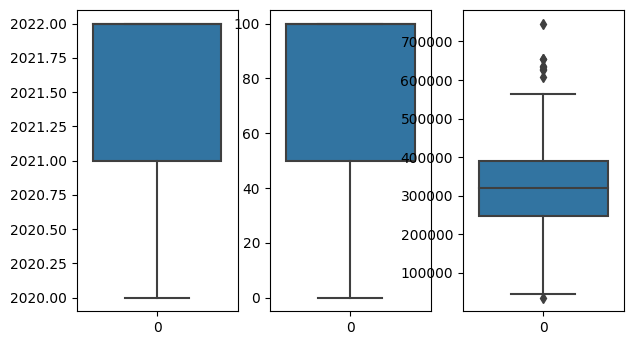

In [7]:
plt.figure(figsize=(22,18))
for i,col in enumerate(num_df.columns):
    plt.subplot(4,9,i+1)
    sns.boxplot(num_df[col])

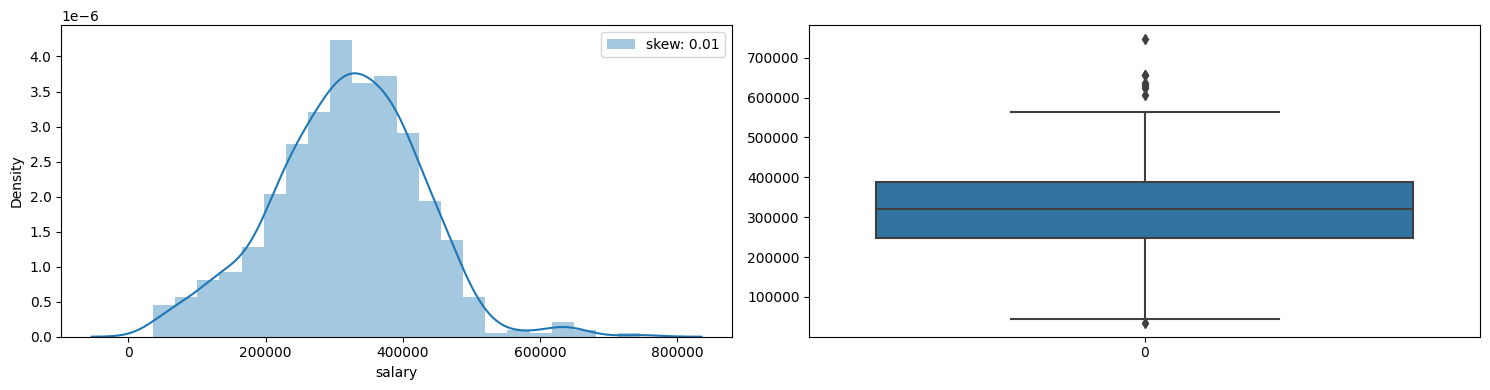

In [8]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sns.distplot(df['salary'], label="skew: " + str(np.round(df['salary'].skew(),2)))
plt.legend()
plt.subplot(122)
sns.boxplot(df['salary'])
plt.tight_layout()
plt.show()

In [9]:
df_cap = df.copy()

### Interquartile Range Method( IQR ) method


#### Why are we capping it and why not trim it ?
- Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

- In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [10]:
def iqr_capping(df, col, factor):
     
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1

    upper_whisker = q3 + (factor*iqr)
    lower_whisker = q1 - (factor*iqr)

    df[col] = np.where(df[col]>upper_whisker, upper_whisker,
    np.where(df[col]<lower_whisker, lower_whisker, df[col]))

In [11]:
iqr_capping(df_cap, 'salary', 1.5)

#### After Outliers Capping


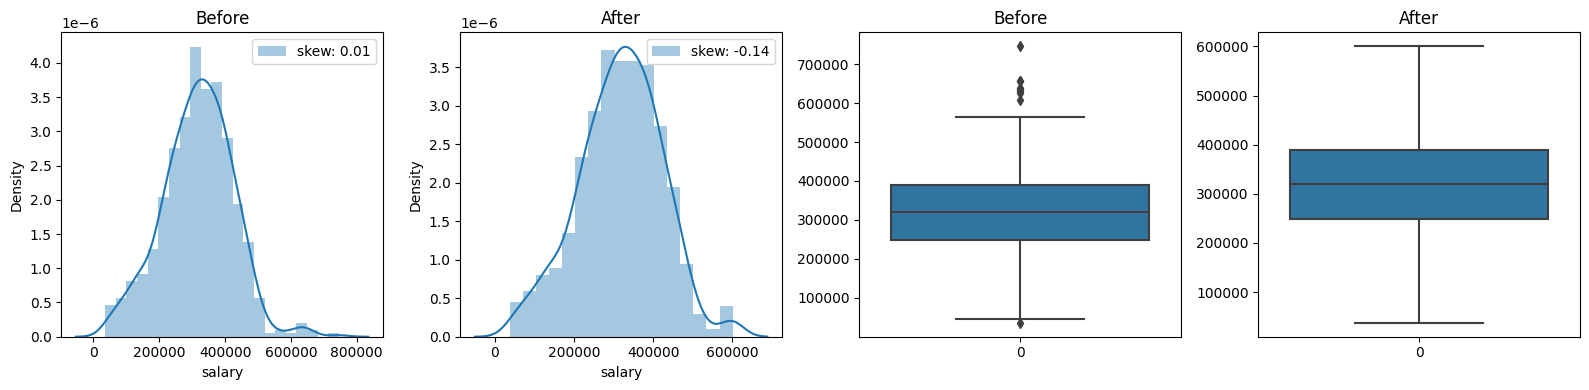

In [12]:
plt.figure(figsize=(16,4))
    
plt.subplot(141)
sns.distplot(df['salary'], label="skew: " + str(np.round(df[col].skew(),2)))
plt.title('Before')
plt.legend()

plt.subplot(142)
sns.distplot(df_cap['salary'], label="skew: " + str(np.round(df_cap[col].skew(),2)))
plt.title('After')
plt.legend()

plt.subplot(143)
sns.boxplot(df['salary'])
plt.title('Before')

plt.subplot(144)
sns.boxplot(df_cap['salary'])
plt.title('After')
plt.tight_layout()
plt.show()

#### Compare Skewness


In [13]:
df['salary'].skew()

0.013615414121355097

In [14]:
df_cap['salary'].skew()

-0.14176411428213856

### Multicollinearity Check


#### Variance Inflation Factor (VIF)
- Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
- Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [16]:
compute_vif(numeric_features, df)

,Variable,VIF
0,work_year,1.060969
1,remote_ratio,1.023083
2,salary,1.077040


#### A VIF of 1 for a given independent variable indicates the total absence of collinearity between this variable and other predictors in the model
- 1 = not correlated.
- Between 1 and 5 = moderately correlated.
- Greater than 5 = highly correlated.

#### Feature Encoding and Scaling

In [17]:
label_encoder = LabelEncoder()
df['experience_level']= label_encoder.fit_transform(df['experience_level'])
df['employment_type']= label_encoder.fit_transform(df['employment_type'])
df['Updated_Job_Title']= label_encoder.fit_transform(df['Updated_Job_Title'])
df['employee_residence']= label_encoder.fit_transform(df['employee_residence'])
df['company_location']= label_encoder.fit_transform(df['company_location'])
df['company_size']= label_encoder.fit_transform(df['company_size'])

In [18]:
X = df.drop(labels = ['salary'], axis = 1)
y = df[['salary']]

In [19]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

#### Train Test Split
- The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.
- It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

#### Model Selection
- Here we should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning.

In [27]:
model = {
    'XGB': XGBRegressor(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Elastic Net': ElasticNet(),
    'Bayesian Ridge': BayesianRidge(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor()
}

result = pd.DataFrame(columns=['Model', 'Avg_RMSE'])

for name, mod in model.items():
    model = mod
    crossvad = cross_validate(model, x_train, y_train, cv=10, scoring=['neg_root_mean_squared_error'])
    avg_rmse = np.abs(crossvad['test_neg_root_mean_squared_error']).mean()
    new_row = {'Model': name, 'Avg_RMSE': avg_rmse}
    result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)

result = result.sort_values('Avg_RMSE', ascending=True)
result = result.reset_index(drop=True)
print(result)

               Model       Avg_RMSE
0  Gradient Boosting   72398.923733
1                XGB   80714.031260
2     Bayesian Ridge   91005.164780
3              Ridge   91068.873034
4              Lasso   91082.242917
5        Elastic Net   91837.818956
6                SVR  107375.713466


In [28]:
gb = GradientBoostingRegressor(random_state=42)
params = {
    'loss' : ('squared_error', 'absolute_error'),
    'learning_rate' : (1.0, 0.1, 0.01),
    'n_estimators' : (50, 100, 200)
}

model1 = GridSearchCV(gb, params, cv=10)
model1.fit(x_train, y_train)
print('Best hyperparameter : ', model1.best_params_)

Best hyperparameter :  {'learning_rate': 0.1, 'loss': 'absolute_error', 'n_estimators': 100}


In [29]:
y_pred = model1.predict(x_train)
print(f'Train RMSE : {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE : 64411.64295856863


In [30]:
xgb = XGBRegressor(random_state=42)
params = {
    'max_depth' : (3, 6, 9),
    'learning_rate' : (0.3, 0.1, 0.05),
    'n_estimators' : (50, 100, 200)
}

model2 = GridSearchCV(xgb, params, cv=10)
model2.fit(x_train, y_train)
print('Best hyperparameter : ', model2.best_params_)

Best hyperparameter :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [31]:
y_pred = model2.predict(x_train)
print(f'Train RMSE : {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE : 62002.94854934175


In [33]:
import pickle
 
# Save the trained model as a pickle file.
pickle.dump(model2, open('model.pkl', 'wb'))